# Singapore rainfall analysis with ARMA

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('rainfall.csv')
df

,month,total_rainfall
0,1982-01,107.1
1,1982-02,27.8
2,1982-03,160.8
3,1982-04,157.0
4,1982-05,102.2
...,...,...
458,2020-03,108.8
459,2020-04,188.0
460,2020-05,255.6
461,2020-06,233.8


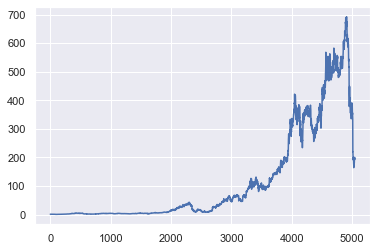

In [3]:
df2 = pd.read_csv('NFLX.csv')
plt.plot([*range(len(df2.Date.values))], df2.Open.values)
plt.show()

# Data visualisation

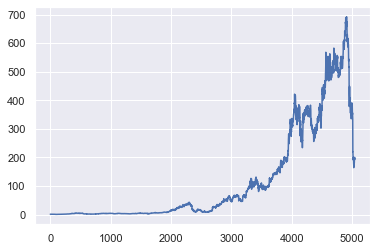

In [4]:
# date = df.month.values
# rainfall = df.total_rainfall.values
date = [*range(len(df2.Date.values))]
rainfall = df2.Open.values

plt.plot(date, rainfall)
plt.show()

# Data preparation

### ACF, PACF for raw data

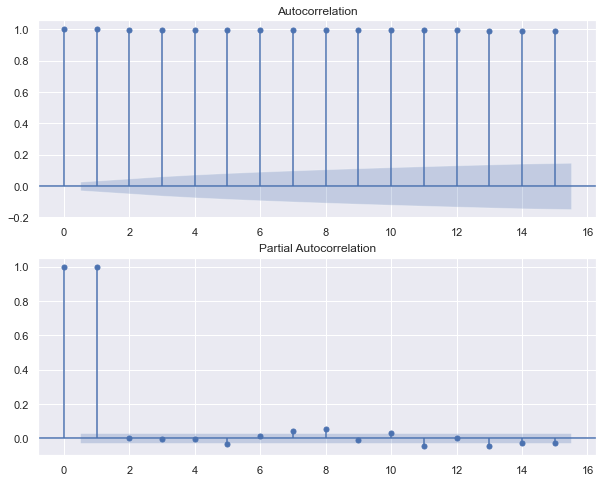

In [5]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(rainfall, lags = 15, ax=ax[0])
plot_pacf(rainfall, lags = 15, ax=ax[1], method='ols')
plt.show()

### ADF test - for stationarity

In [6]:
def adf(data):
    adf = adfuller(data)
    print('Test statistic: ' +  str(adf[0]))
    print('P-value: ' +  str(adf[1]))

In [7]:
adf(rainfall)
print('Series is not stationary')

Test statistic: -1.3336726659953988
P-value: 0.6136297419105514
Series is not stationary


### Variance stabilization - Box-Cox Transformation

In [8]:
rainfall2, lmb = stats.boxcox(rainfall)

In [29]:
lmb

-0.02140962164007086

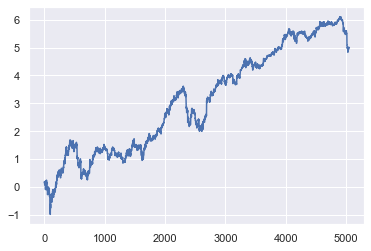

In [30]:
plt.plot(date, rainfall2)

In [31]:
adf(rainfall2)
print('Series is not stationary')

Test statistic: -1.2386174750248522
P-value: 0.6567668529876127
Series is not stationary


### Histograms of data (before and after Box-Cox Transformation)

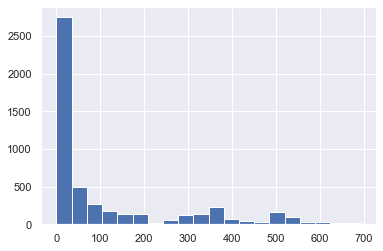

In [32]:
plt.hist(rainfall, bins = 20)
plt.show()

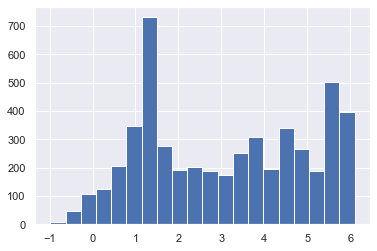

In [33]:
plt.hist(rainfall2, bins = 20)
plt.show()

### Trend decomposition

In [34]:
def trend(data):
    array1 = data[:1]
    array2 = data[1:] - data[:(len(data) - 1)]
    return np.array(list(array1) + list(array2))

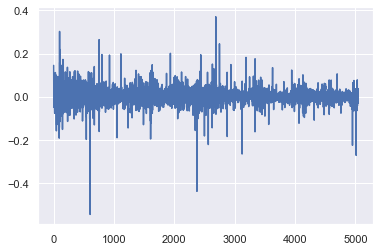

In [35]:
rainfall3 = trend(rainfall2)
plt.plot(date, rainfall3)
plt.show()

In [36]:
adf(rainfall3)
print('Series is stationary')

Test statistic: -31.696922569094905
P-value: 0.0
Series is stationary


### Seasonality decomposition (it's not necessary, there is not visible seasonality)

In [37]:
def season(data, m = 365):
    array1 = data[:m]
    array2 = data[m:] - data[:(len(data) - m)]
    return np.array(list(array1) + list(array2))

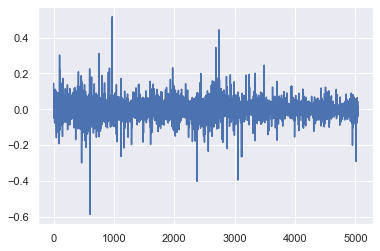

In [38]:
rainfall4 = season(rainfall3)
plt.plot(date, rainfall4)
plt.show()


In [39]:
adf(rainfall4)
print('Series is stationary')

Test statistic: -14.151956449583382
P-value: 2.1541229469805177e-26
Series is stationary


### ACF, PACF for decomposed data

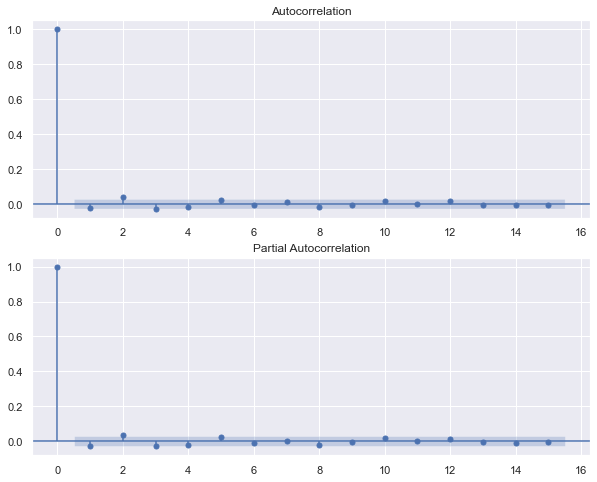

In [19]:
width = 10
height = 4

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(rainfall3, lags = 15, ax=ax[0])
plot_pacf(rainfall3, lags = 15, ax=ax[1], method='ols')
plt.show()

# Fitting ARMA model

In [20]:
def optimize_ARIMA(order_list, exog):
    """
        Return dataframe with parameters and corresponding AIC
        
        order_list - list with (p, d, q) tuples
        exog - the exogenous variable
    """
    
    results = []
    
    for order in tqdm_notebook(order_list):
        try: 
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
            
        aic = model.aic
        results.append([order, model.aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p, d, q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [27]:
def fit_ARIMA(data, pmax = 10, qmax = 10, d = 1):
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
    warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

    rows = []
    best_params = 0
    best_aic = SARIMAX(data, order = (1, 1, 1)).fit(disp = -1).aic
    
    for q in range(1, qmax + 1):
        row = []
        for p in range(1, pmax + 1):
            params = (p, d, q)
            model = SARIMAX(data, order = params).fit(disp = -1)
            aic = model.aic
            row.append(aic)
            if aic < best_aic:
                best_aic = aic
                best_params = params
        rows.append(row)
#     sns.heatmap(rows, cmap = "Greens", xticklabels=[*range(1, pmax + 1)], yticklabels=[*range(1, qmax + 1)], cbar_kws={'label': 'AIC', 
#                                                                                                       'shrink' : 1.2})
#     plt.ylim(0, qmax)
#     plt.xlabel('p', fontsize = 15)
#     plt.ylabel('q', fontsize = 15)
#     plt.show()
    return best_params

In [28]:
x = fit_ARIMA(rainfall3)
print(x)

(2, 1, 3)


# Rating our ARMA model

In [130]:
print([*range(20)])

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


# Residuum analysis

# Conclusion

# References

https://www.statology.org/dickey-fuller-test-python/

https://el.us.edu.pl/ekonofizyka/index.php/Analiza_Szereg%C3%B3w_Czasowych/Dekompozycja_szeregu_czasowego#Metoda_S3:_R.C3.B3.C5.BCnicowanie_z_przesuni.C4.99ciem_d

https://towardsdatascience.com/advanced-time-series-analysis-with-arma-and-arima-a7d9b589ed6d

https://plotly.com/python/heatmaps/